# Dice Loss

In [34]:
%load_ext autoreload
%autoreload 2

import os
import torch
import random

import numpy as np
import diveslowlearnfast as dlf
import matplotlib.pyplot as plt

from diveslowlearnfast.config import Config
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast import load_checkpoint
from diveslowlearnfast.train.helper import get_train_transform, get_test_transform, get_mask_transform, get_base_transform
from diveslowlearnfast.models import SlowFast
from diveslowlearnfast.egl import ExplainerStrategy
from diveslowlearnfast.transforms import KwargsCompose, DeterministicRandomShortSideScale, DeterministicRandomCrop, DeterministicHorizontalFlip, get_deterministic_transform_params

from torchvision.transforms.v2 import Compose, CenterCrop
from pytorchvideo.transforms import ShortSideScale


cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 4
cfg.DATA.TEST_CROP_SIZE = 224
cfg.EGL.METHOD = 'gradcam'
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']

vidnames = ['3qq031609lA_00002', 'iv0Gu1VXAgc_00167', 'aektxm8cLdo_00000']

diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=get_test_transform(cfg),
    mask_transform_fn=get_mask_transform(cfg),
    video_ids=vidnames,
    loader_mode='jpg',
    mask_type='segments'
)

loader = torch.utils.data.DataLoader(
    diving48,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model)
model, *_ = load_checkpoint(model, '../misc/checkpoint.pth', optimiser, device)

explainer = ExplainerStrategy.get_explainer(model, cfg, device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [ ]:
xb, yb, _, _, video_ids, mb = next(iter(loader))
xb.shape, yb.shape, mb.shape

In [5]:
a = [1, 2, 3, 4]
print(a)

a[-2:]

[1, 3, 4]


[3, 4]

## Testing our Transform
Our transform function should apply the same spatial transformations since we are setting the same seed for both the segmentation mask and the video frames.

torch.Size([3, 32, 224, 224])


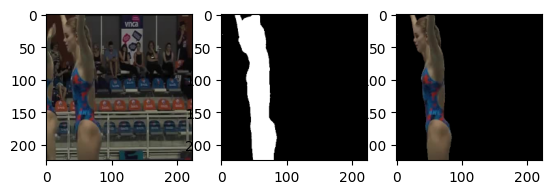

In [12]:
transform = KwargsCompose([
    DeterministicRandomShortSideScale(),
    DeterministicRandomCrop(cfg.DATA.TEST_CROP_SIZE),
    DeterministicHorizontalFlip()
])

diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    video_ids=vidnames,
    loader_mode='jpg',
    mask_type='segments'
)

x, y, _, _, video_id, _, indices = diving48[0]

x = torch.tensor(x / 255., dtype=torch.float32).permute(3, 0, 1, 2)
_, _, h, w = x.shape
params = get_deterministic_transform_params(h, w, (cfg.DATA.TEST_CROP_SIZE, cfg.DATA.TEST_CROP_SIZE))
x = transform(x, **params)
print(x.shape)
ax = plt.subplot(1, 3, 1)
ax.imshow(x.permute(1, 2, 3, 0)[0])

m = dlf.read_diver_segmentation_mask(
    os.path.join(cfg.DATA.DATASET_PATH, 'Segments', video_id),
    indices
)
m = torch.from_numpy(np.float32(m))
T, H, W = m.shape
m = m.unsqueeze(1).expand(T, 3, H, W).permute(1, 0, 2, 3)

m = transform(m, **params)

ax = plt.subplot(1, 3, 2)
ax.imshow(m.permute(1, 2, 3, 0)[0])

mx = m * x

ax = plt.subplot(1, 3, 3)
ax.imshow(mx.permute(1, 2, 3, 0)[0])

## Testing Deterministic Transform (e2e)
The code block below contains a test that shows our 'deterministic transforms' working as an integration with the `Diving48Dataset`.

Acceptance criteria:

1. Any transform can be applied
2. only when `CutoutSegmentTransform` is applied the does the mask need to align with the input

torch.Size([3, 32, 224, 224])


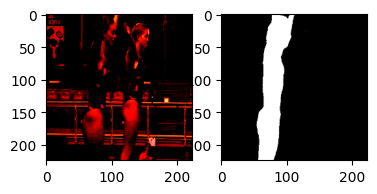

In [92]:
cfg.CUTOUT_SEGMENT.ENABLED = True
cfg.RAND_AUGMENT.ENABLED = True
cfg.RANDOM_APPLY_TRANSFORM.ENABLED = True
cfg.RANDOM_APPLY_TRANSFORM.PROB = 0.333
cfg.CUTOUT_SEGMENT.SEGMENTS_PATH = 'data/Segments'

diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=get_train_transform(cfg, (cfg.DATA.TEST_CROP_SIZE, cfg.DATA.TEST_CROP_SIZE)),
    mask_transform_fn=get_mask_transform(cfg),
    video_ids=vidnames,
    loader_mode='jpg',
    mask_type='segments',
    crop_size=(cfg.DATA.TEST_CROP_SIZE, cfg.DATA.TEST_CROP_SIZE),
)

x, y, _, _, _, m, _ = diving48[0]

print(x.shape)
ax = plt.subplot(1, 3, 1)
ax.imshow(x.permute(1, 2, 3, 0)[0])


ax = plt.subplot(1, 3, 2)
ax.imshow(m.permute(1, 2, 3, 0)[0])

# mx = m * x
#
# ax = plt.subplot(1, 3, 3)
# ax.imshow(mx.permute(1, 2, 3, 0)[0])

In [ ]:
def get_segmenat(idx, indices, vidnames):
    segment = dlf.read_diver_segmentation_mask(
        os.path.join(cfg.DATA.DATASET_PATH, 'Segments', vidnames[idx]),
        indices[idx]
    )
    transform = Compose([
        ShortSideScale(size=256),
        CenterCrop(cfg.DATA.TEST_CROP_SIZE),
    ])
    T, H, W = segment.shape
    segment = torch.from_numpy(segment)
    segment = segment.unsqueeze(1).expand(T, 3, H, W).permute(1, 0, 2, 3).float()
    segment = transform(segment)
    return segment[0, :].squeeze(0).to(torch.bool)

In [ ]:
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA)
exp, logits = explainer(inputs, y=yb)
exp_slow = exp[0]
exp_fast = exp[1]
pred = torch.softmax(logits, dim=-1).argmax(dim=-1)

exp_slow.shape, exp_fast.shape, logits.shape, pred, yb, exp[0].requires_grad, logits.requires_grad

In [ ]:
xb, yb, video_ids, indices, *_ = next(iter(loader))
xb.shape, yb.shape, indices

In [ ]:
from diveslowlearnfast.visualise.gradcam import get_layer

# Forward pass to get feature maps and output
# Store all activations in a dictionary
activations = {}

model.zero_grad()
for param in model.parameters():
    param.requires_grad = True

def save_activation(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

target_layer = get_layer(model, 's5/pathway1_res2')

handle = target_layer.register_forward_hook(save_activation('target'))

inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA, requires_grad=True)

output = model(inputs)

score = torch.gather(output, dim=1, index=yb.unsqueeze(-1)).sum()

# Check before proceeding
target_activations = activations['target']
print(f"Activation shape: {target_activations.shape}")
print(f"Activation requires grad: {target_activations.requires_grad}")
print(f"Score requires grad: {score.requires_grad}")

# Try the grad calculation with debugging

try:
    # gradients = torch.autograd.grad(score, target_activations, create_graph=True)[0]
    gradients = torch.autograd.grad(score, target_activations, create_graph=True)[0]
    print(f"Gradient shape: {gradients.shape}")
except RuntimeError as e:
    print(f"Error: {e}")
    # Try with allow_unused as a fallback
    gradients = torch.autograd.grad(score, target_activations, create_graph=True, allow_unused=True)[0]

# Remove the hook
handle.remove()

In [ ]:
import torch.nn.functional as F


def gradcam(model, inputs, labels, layer_names):
    activations = {}
    def save_activation(name):
        def hook(_module, _input, output):
            activations[name] = output
        return hook

    layers = [get_layer(model, layer) for layer in layer_names]
    handles = []
    for layer_name, layer in zip(layer_names, layers):
        handles.append(layer.register_forward_hook(save_activation(layer_name)))

    logits = model(inputs)
    score = torch.gather(logits, dim=1, index=labels.unsqueeze(-1)).sum()
    localization_maps = []
    for i, (inp, layer_name) in enumerate(zip(inputs, layer_names)):
        _, _, T, H, W = inp.size()

        target_activations = activations[layer_name]
        gradients = torch.autograd.grad(score, target_activations, create_graph=True, retain_graph=True)[0]
        # print(target_activations.requires_grad)
        # print(gradients.requires_grad)

        B, C, Tg, _, _ = gradients.size()
        weights = torch.mean(gradients.view(B, C, Tg, -1), dim=3)

        weights = weights.view(B, C, Tg, 1, 1)
        localization_map = torch.sum(weights * target_activations, dim=1, keepdim=True)
        localization_map = F.relu(localization_map)
        localization_map = F.interpolate(
            localization_map,
            size=(T, H, W),
            mode="trilinear",
            align_corners=False,
        )
        localization_map_min, localization_map_max = (
            torch.min(localization_map.view(B, -1), dim=-1, keepdim=True)[0],
            torch.max(localization_map.view(B, -1), dim=-1, keepdim=True)[0],
        )
        localization_map_min = torch.reshape(
            localization_map_min, shape=(B, 1, 1, 1, 1)
        )
        localization_map_max = torch.reshape(
            localization_map_max, shape=(B, 1, 1, 1, 1)
        )
        localization_map = (localization_map - localization_map_min) / (
            localization_map_max - localization_map_min + 1e-6
        )

        localization_maps.append(localization_map)

    [handle.remove() for handle in handles]
    return localization_maps, logits




model.zero_grad()
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA, requires_grad=True)
exp, logits = gradcam(model, inputs, yb, ['s5/pathway0_res2', 's5/pathway1_res2'])
exp_slow = exp[0]
exp_fast = exp[1]

## Dice Loss - Method
In this section we explore the application of a Dice loss, defined by $\mathcal{L}_{\text{Dice}} = 1 - (2 \cdot I) / (P + G)$, where $I$ is the __area of intersection__, $P$ the __area of prediction__, and $G$ the __ground truth area__. Here, we attempt to compare the binary mask of the GradCAM output with that of Optical Flow (**OF**), in this instance OF will act as a ground truth label.

In [ ]:
def dice_loss(pred, target, smooth=1e-8):
    batch_size = pred.size(0)
    predictions_flat = pred.view(batch_size, -1)
    targets_flat = target.view(batch_size, -1)

    intersection = torch.min(predictions_flat, targets_flat).sum(dim=1)
    predictions_sum = predictions_flat.sum(dim=1)
    targets_sum = targets_flat.sum(dim=1)

    dice = (2.0 * intersection + smooth) / (predictions_sum + targets_sum + smooth)

    return 1.0 - dice.mean()

dloss = dice_loss(exp_slow, exp_slow)
dloss.backward()

In [ ]:
segment = get_segment(1, indices, video_ids)[::cfg.SLOWFAST.ALPHA]
plt.imshow(segment[2], cmap='gray')

In [ ]:
exp_softmax = torch.softmax(exp[0], dim=(-1, -2))

In [ ]:
plt.imshow(exp[0][1][0][2].detach())

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()(logits, yb)

total_loss = dloss + ce_loss
total_loss.backward()
print(exp_bin.requires_grad)
total_loss, dloss, ce_loss

In [ ]:
exp_detach = [e.detach() for e in exp]
heatmaps = dlf.create_heatmaps(inputs, exp_detach, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
heatmap_slow = heatmaps[0]

dlf.frameshow(heatmap_slow[1].permute(1, 2, 3, 0), frame_idx=2)

In [ ]:
loss = torch.nn.CrossEntropyLoss()(logits, yb)
loss.backward()

In [ ]:
loss.item()